# Chapter 1

In [1]:
import requests_cache
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import acf

In [2]:
session = requests_cache.CachedSession('yfinance.cache')
session.headers['User-Leonardo'] = 'Chapter_1'

In [3]:
# sp500_data = yf.download('^GSPC')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# sp500_data.to_excel(r"C:\Users\leocr\Projects\Economics\Finance\Risk Management\data_sp500.xlsx")

In [3]:
stoxx50e_data = yf.download('^STOXX50E')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# stoxx50e_data.to_excel(r"C:\Users\leocr\Projects\Economics\Finance\Risk Management\data_stoxx50e.xlsx")

In [5]:
prices = stoxx50e_data.Close['^STOXX50E']
prices

Date
2007-03-30    4181.029785
2007-04-02    4189.549805
2007-04-03    4246.299805
2007-04-04    4261.830078
2007-04-05    4271.540039
                 ...     
2025-03-04    5387.310059
2025-03-05    5489.120117
2025-03-06    5520.470215
2025-03-07    5468.410156
2025-03-10    5421.189941
Name: ^STOXX50E, Length: 4499, dtype: float64

In [6]:
prices.describe()

count    4499.000000
mean     3390.464277
std       713.177804
min      1809.979980
25%      2876.529907
50%      3326.239990
75%      3785.290039
max      5540.689941
Name: ^STOXX50E, dtype: float64

In [7]:
prices = prices.to_numpy()

In [8]:
dates = stoxx50e_data.Close['^STOXX50E'].index

## Returns

In [9]:
returns = np.log(prices[1:])- np.log(prices[:-1])
mean = returns.mean()
variance = returns.var()
print('average = ',mean, '\nvariance = ', variance)

average =  5.7749613485874005e-05 
variance =  0.00019457044019945474


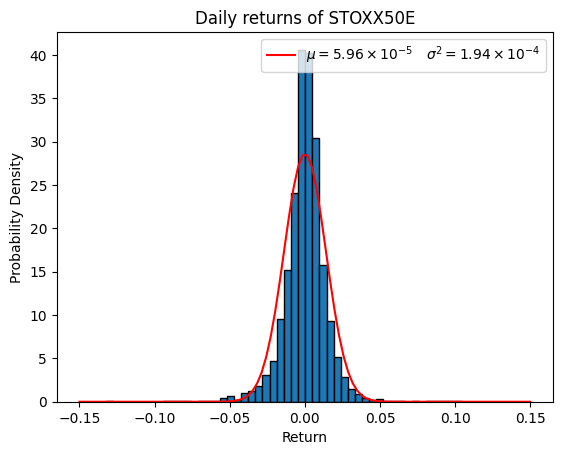

In [10]:
# Generate a range of x values for the normal distribution
x = np.linspace(-0.15, 0.15, 100)
# Evaluate the normal distribution at the x values
y = sp.stats.norm(loc =mean, scale = np.sqrt(variance)).pdf(x)

# Plot the histogram
plt.hist(returns, bins=50, edgecolor='black', density=True)
# Plot the fitted distribution
plt.plot(x, y, 'r-', label=r'$\mu = 5.96\times 10^{-5} \quad \sigma^2 = 1.94\times 10^{-4}$')
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.title('Daily returns of STOXX50E')
plt.legend()
plt.show()

## Autocorrelations

In [11]:
max_lag = 100
# Calculate autocorrelation for lags 1 to 100
autocorr_values = acf(returns, nlags=max_lag)

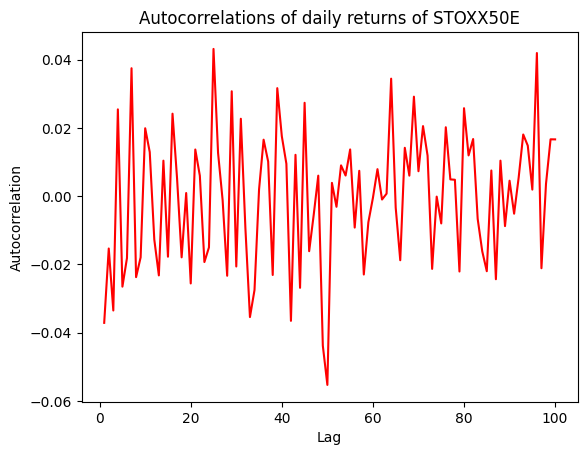

In [12]:
x = np.arange(max_lag+1)

plt.plot(x[1:], autocorr_values[1:], 'r-')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelations of daily returns of STOXX50E')
plt.show()

## Squared Autocorrelations

In [13]:
# Calculate autocorrelation for lags 1 to 100
sq_autocorr_values = acf(returns**2, nlags=max_lag)

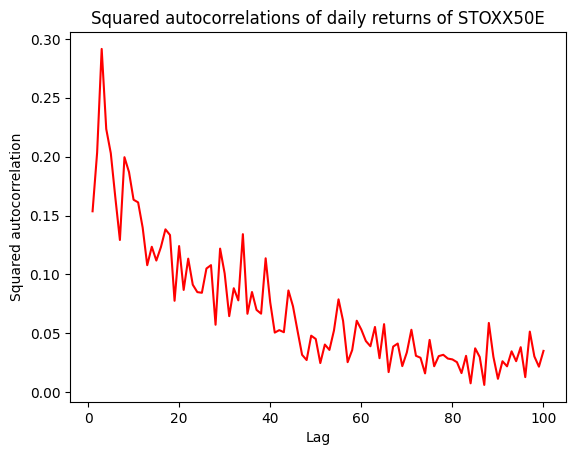

In [14]:
plt.plot(x[1:], sq_autocorr_values[1:], 'r-')
plt.xlabel('Lag')
plt.ylabel('Squared autocorrelation')
plt.title('Squared autocorrelations of daily returns of STOXX50E')
plt.show()

## Riskmetrics

In [15]:
def risk_metrics(returns, persistence):
    t_max = len(returns)
    volatility = np.zeros(t_max)
    volatility[0] = returns.var()
    for t in range(1, t_max):
        volatility[t] = persistence*volatility[t-1] + (1-persistence)*returns[t]**2
    return volatility

In [16]:
volatility = risk_metrics(returns, 0.94)

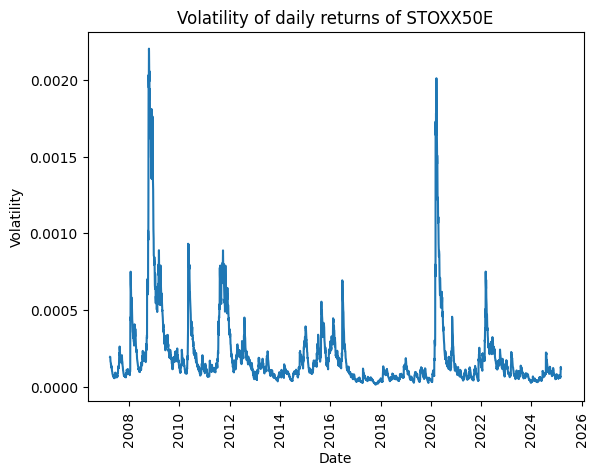

In [17]:
plt.plot(dates[:-1],volatility)
# rotate x-tick-labels by 90°
plt.tick_params(axis='x',rotation=90)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility of daily returns of STOXX50E')
plt.show()

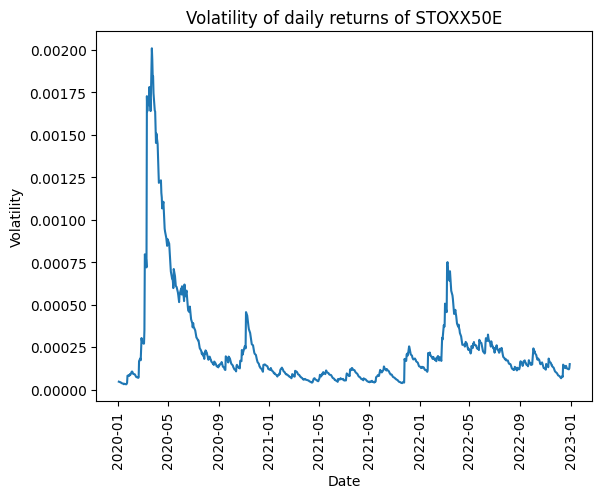

In [18]:
start_date = np.datetime64('2020-01-01')
end_date = np.datetime64('2022-12-31')

mask = (dates[:-1] >= start_date) & (dates[:-1] <= end_date)

plt.plot(dates[:-1][mask], volatility[mask])
# rotate x-tick-labels by 90°
plt.tick_params(axis='x', rotation=90)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility of daily returns of STOXX50E')
plt.show()

## RM VaR
RiskMetrics VaR assuming gaussian distribution of portfolio returns

In [19]:
p = 0.01
#quantile = sp.stats.norm.ppf(p, loc=mean, scale=np.sqrt(variance))
quantile = sp.stats.norm.ppf(p, loc=0, scale=1)
print(-quantile)

2.3263478740408408


## HS VaR

VaR from historical simulation

In [20]:
len_ret = len(returns)
hs_var = np.zeros(len_ret)
hs_span = 250

for t in range(1,len_ret-hs_span):
    hs_var[t+hs_span] = -np.percentile(returns[t:t+hs_span], 100*p)

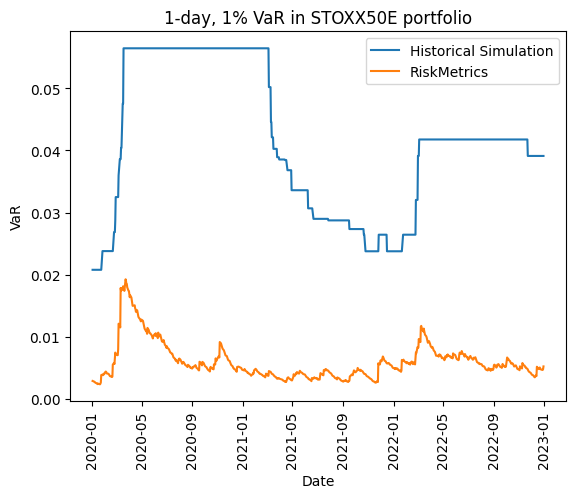

In [21]:
plt.plot(dates[:-1][mask],  hs_var[mask], label = 'Historical Simulation')
plt.plot(dates[:-1][mask], -quantile ** (-1) *np.sqrt(volatility[mask]), label = 'RiskMetrics')
# rotate x-tick-labels by 90°
plt.tick_params(axis='x', rotation=90)
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('1-day, 1% VaR in STOXX50E portfolio')
plt.legend()
plt.show()

# Chapter 2

## HS - Using Pseudo Returns

Find data for all the components of EUROSTOXX50

In [22]:
# Open the file in read mode
with open('Tickers', 'r') as file:
    # Read all lines into a list and strip newline characters
    tickers = [line.strip() for line in file.readlines()]

# Print the list of tickers
print(len(tickers))


50


In [23]:
# Download data for all tickers
data = yf.download(tickers, period='1d')

[*********************100%***********************]  50 of 50 completed


In [24]:
market_caps = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_caps[ticker] = stock.info.get("marketCap", 0)

In [25]:
# Convert to DataFrame
df = pd.DataFrame(market_caps.items(), columns=["Ticker", "MarketCap"])
df["Weight"] = df["MarketCap"] / df["MarketCap"].sum() * 100  # Normalize weights
df = df.sort_values(by="Weight", ascending=False)

print(df)

       Ticker     MarketCap    Weight
27      MC.PA  323843981312  7.391322
36     SAP.DE  288322715648  6.580595
6     ASML.AS  254346362880  5.805128
26     LIN.DE  207340503040  4.732280
29      OR.PA  198712967168  4.535368
37     SIE.DE  177790271488  4.057834
24     ITX.MC  156898738176  3.581012
35     SAN.PA  138546757632  3.162151
44     UNA.AS  138183426048  3.153859
30  ORSTED.CO  137248759808  3.132526
4      AIR.PA  135623827456  3.095439
5      ALV.DE  132640366592  3.027346
41     TTE.PA  126695440384  2.891660
14      EL.PA  125193420800  2.857379
39      SU.PA  124058959872  2.831486
0      ABI.BR  112921534464  2.577289
3       AI.PA  106021535744  2.419805
34     SAF.PA  105710706688  2.412711
21     IBE.MC   86075162624  1.964555
10     BNP.PA   85483200512  1.951044
23     ISP.MI   85427486720  1.949772
49    ZURN.SW   85342535680  1.947833
42     UCG.MI   82436825088  1.881514
28    MUV2.DE   75467390976  1.722446
8     BBVA.MC   73886212096  1.686358
15    ENEL.M

In [26]:
# Download data for all tickers
historical_data = yf.download(tickers, start='2010-01-01').fillna(0)

[*********************100%***********************]  50 of 50 completed


In [27]:
hs_dates = historical_data.Close[tickers[0]].index

In [28]:
pseudo_values = 0
for index, row in df.iterrows():
    historical_prices = historical_data.Close[row["Ticker"]].to_numpy()
    pseudo_values= pseudo_values + historical_prices*row["Weight"]
print(len(pseudo_values))

3925


In [29]:
for i in range(len(pseudo_values)):
    pv = pseudo_values[i]
    if pv<=0:
        print(i,pv)
        
print(np.log(pseudo_values))

[ 8.76320178  8.75493425  8.74971417 ... 10.84986011 10.81127283
 10.79347455]


In [30]:
pseudo_returns = np.log(pseudo_values[1:])-np.log(pseudo_values[:-1])
pr_mean =pseudo_returns.mean()
pr_variance = pseudo_returns.var()
print(pr_mean,pr_variance)

0.0005173987699695202 0.7038642772030558


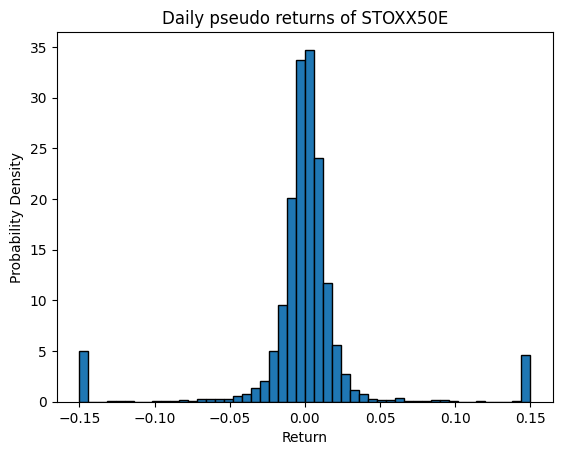

In [31]:
# Plot the histogram
plt.hist(np.clip(pseudo_returns,-0.15,0.15), bins=50, edgecolor='black', density=True)
plt.xlabel('Return')
plt.ylabel('Probability Density')
plt.title('Daily pseudo returns of STOXX50E')
plt.show()

In [32]:
len_pr = len(pseudo_returns)
hs_var = np.zeros(len_pr)
hs_span = 250

for t in range(1,len_pr-hs_span):
    hs_var[t+hs_span] = -np.percentile(pseudo_returns[t:t+hs_span], 100*p)

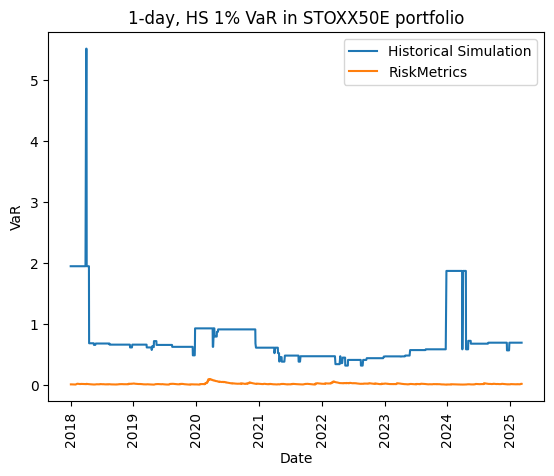

In [33]:
start_date = np.datetime64('2018-01-01')
end_date = np.datetime64('2025-12-31')

mask = (dates[:-1] >= start_date) & (dates[:-1] <= end_date)
hs_mask = (hs_dates[:-1] >= start_date) & (hs_dates[:-1] <= end_date)

plt.plot(hs_dates[:-1][hs_mask], hs_var[hs_mask], label = 'Historical Simulation')
plt.plot(dates[:-1][mask], -quantile * np.sqrt(volatility[mask]), label = 'RiskMetrics')
# rotate x-tick-labels by 90°
plt.tick_params(axis='x', rotation=90)
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('1-day, HS 1% VaR in STOXX50E portfolio')
plt.legend()
plt.show()


# Chapter 2

In [ ]:
from arch.univariate import arch_model

In [37]:
garch = arch_model(returns, p=1, q=1, o=0, dist='normal')
results = garch.fit()

In [41]:
print(results)

{'omega': np.float64(0.04442726608620073),
 'alpha': np.float64(0.11573146834588117),
 'beta': np.float64(0.8610034808086845),
 'variance': np.float64(0.00019096139690973199)}